# Imports

In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import load_img,img_to_array
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
from collections import Counter
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import ListedColormap
import matplotlib.image as mpimg
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import time
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Sequential
from keras.initializers import TruncatedNormal
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Flatten, Conv1D ,Input,MaxPooling1D, Dropout,AveragePooling1D, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, GlobalAveragePooling2D
from keras.models import load_model
from keras.models import Model
from keras.utils import to_categorical
import keras.losses
from keras.optimizers import SGD
import pickle
from sklearn.utils import shuffle
from sklearn.manifold import TSNE

Using TensorFlow backend.


# Functions

In [2]:
def train_dev_test_split(images, labels):
    #train->0.7, dev->0.15, test->0.15
    frac_train=0.7
    frac_test=0.15
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=frac_test, random_state=78)
    frac_dev=0.15/(frac_train+frac_test)
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=frac_dev, random_state=78)
    print("Train Set:",X_train.shape, "| Dev Set:",X_dev.shape, "| Test Set:",X_test.shape )
    return(X_train, X_test, X_dev, y_train, y_test, y_dev)

In [3]:
def feature_selection(images,variance_lower_limit):
    selector = VarianceThreshold(variance_lower_limit)
    images_reduced = selector.fit_transform(images)
    print("Images original shape: ",images.shape)
    print("Images reduced shape: ",images_reduced.shape)
    return images_reduced

In [4]:
#convert raw rgb image to normalized in [0,1] one-hot vectors
def load_reshape_img(img):
    x = img_to_array(img)/255.
    x = x.reshape((1,)+x.shape)
    x = x.flatten()
    return x

In [5]:
#convert the dataset with features the image names to dataset with features theflattened one hot encoding vectors of pixels
offset_height=40
offset_width=30
target_height=30
target_width=50

def create_flattened_dataset(dataset,size,crop_bool):
    dataset_copy=dataset.copy()
    for i in dataset:
        img_name=images_folder + i
        img = load_img(img_name, target_size=size)
        #cropped image size = (30,50,3)
        if crop_bool == True:
            x=img_to_array(img)
            x_cropped = tf.image.crop_to_bounding_box(x, offset_height, offset_width, target_height, target_width)
            x_cropped =tf.keras.preprocessing.image.array_to_img(x_cropped, data_format=None, scale=True, dtype=None)
            img_vector=load_reshape_img(x_cropped)
        else:
            img_vector=load_reshape_img(img)
        dataset_copy.loc[int(img_name.split('/')[-1].split('.')[0])] = img_vector
    dataset_np=np.stack(dataset_copy)
    dataset_pd = pd.DataFrame(dataset_np)
    return(dataset_pd)

In [6]:
#check for NaN values in one-hot encodings ,e.g. missing pixels
def check_NaN_values(features,_labels):
    _labels=np.array(_labels)
    NaNvaluesData=np.isnan(_labels).sum().sum()
    if NaNvaluesData>0 :
            where_is_NaN = np.isnan(_labels)
            print("NaN value in labels index: ",where_is_NaN)
    else:
        print("No NaN values in Labels.")
    features=np.array(features)
    NaNvaluesData=np.isnan(features).sum().sum()
    if NaNvaluesData>0 :
        where_is_NaN = np.isnan(features)
        print("Number of NaN values in augmented image: ",where_is_NaN)
    else:
        print("No NaN values in Reshaped Images.")    
    return

In [7]:
#function for SVM classifier with parameters of kernel, gamma and C
def Print_Classification_Results(y_dev,y_pred):
    print(classification_report(y_dev, y_pred))
    acc_score = accuracy_score(y_dev, y_pred)
    print("\nAccuracy Score: ","{:.3%}".format(acc_score))
    conf_matrix = confusion_matrix(y_dev, y_pred)
    labels=['0','1','2','3','4']
    sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=labels, yticklabels=labels,cmap= "BuPu")
    plt.show() 
    return acc_score

In [8]:
def evaluate_and_plot(model, history, X_train, y_train, X_dev, y_dev, y_pred):  
    # evaluate the model
    y_train_c = to_categorical(y_train)
    y_dev_c = to_categorical(y_dev)
    
    train_loss, train_acc = model.evaluate(X_train, y_train_c, verbose=0)
    dev_loss, dev_acc = model.evaluate(X_dev, y_dev_c, verbose=0)
    print('Train: %.3f, Dev: %.3f' % (train_acc, dev_acc))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    # plot loss during training
    ax1.set_title('Loss')
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='dev')
    ax1.legend()
    ax1.set_ylim([-0.1,1])

    # plot accuracy during training
    ax2.set_title('Accuracy')
    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='dev')
    ax2.legend()
    ax2.set_ylim([0,1.2])
    plt.show()

    accuracy = Print_Classification_Results(y_dev,y_pred)
    return(accuracy)

# Read Data

In [9]:
dataset = pd.read_csv('../Datasets/cartoon_set/labels.csv', sep = '\t', usecols = [1,3])
print("Dataset Size: ",dataset.shape)
dataset.head()

Dataset Size:  (10000, 2)


,eye_color,file_name
0,1,0.png
1,2,1.png
2,2,2.png
3,2,3.png
4,0,4.png


In [10]:
images = dataset.iloc[:,1]
labels = dataset.iloc[:,0]

Example of cartoons in Cartoon dataset:

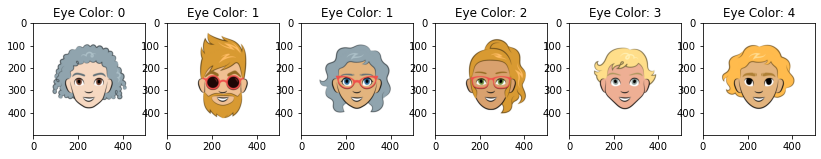

In [11]:
images_folder = '../Datasets/cartoon_set/img/'
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(14, 3))

EXAMPLE_PIC = images_folder + '4.png'
ax1.set_title("Eye Color: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['eye_color']))
img = load_img(EXAMPLE_PIC)
ax1.imshow(img)

EXAMPLE_PIC = images_folder + '0.png'
ax2.set_title("Eye Color: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['eye_color']))
img = load_img(EXAMPLE_PIC)
ax2.imshow(img)

EXAMPLE_PIC = images_folder + '8.png'
ax3.set_title("Eye Color: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['eye_color']))
img = load_img(EXAMPLE_PIC)
ax3.imshow(img)

EXAMPLE_PIC = images_folder + '2.png'
ax4.set_title("Eye Color: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['eye_color']))
img = load_img(EXAMPLE_PIC)
ax4.imshow(img)

EXAMPLE_PIC = images_folder + '6.png'
ax5.set_title("Eye Color: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['eye_color']))
img = load_img(EXAMPLE_PIC)
ax5.imshow(img)

EXAMPLE_PIC = images_folder + '19.png'
ax6.set_title("Eye Color: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['eye_color']))
img = load_img(EXAMPLE_PIC)
ax6.imshow(img)

## Elaborate on multiclass labels

Class=1, n=2018 (20.180%)
Class=2, n=1969 (19.690%)
Class=0, n=2004 (20.040%)
Class=4, n=2017 (20.170%)
Class=3, n=1992 (19.920%)


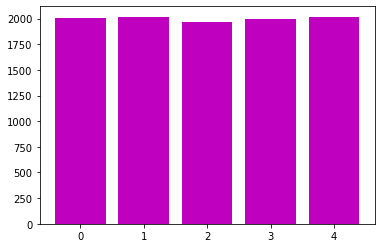

In [12]:
# summarize distribution
counter = Counter(labels)
for k,v in counter.items():
    per = v / len(labels) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values(),color='m')
plt.show()

**Balanced Dataset!!**

## Convert cartoon images dataframe to reshaped flattened array images dataframe

* First, as long as we are interested in cartoon's eye color, which don't need high resolution (since they are cartoons, not human faces), we reduce image shape from (IMG_HEIGHT,IMG_WIDTH)=(500,500) to 110 each, but DO NOT transform images to gray scale, we need color!!!!


* We apply this transformaton from the beginning since we have quite a big dataset with high dimensional features that our computational resources cannot handle in their raw format.

Example of how images will be converted:

Step 1 image size: (500, 500, 3)
Step 2 image size: (110, 110, 3)


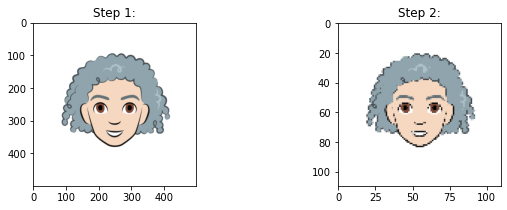

In [12]:
EXAMPLE_PIC = images_folder + '4.png'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

#original image size = (500,500,3)
img_original = load_img(EXAMPLE_PIC,target_size=(500,500))
ax1.imshow(img_original)
ax1.set_title("Step 1:")
print("Step 1 image size:",img_to_array(img_original).shape)

#reduced image size = (150,150,3)
img = load_img(EXAMPLE_PIC,target_size=(110,110))
ax2.imshow(img)
ax2.set_title("Step 2:")
print("Step 2 image size:",img_to_array(img).shape)

plt.show()

In [26]:
size=(110,110)
crop_bool = False
reshaped_images=create_flattened_dataset(images,size,crop_bool)
check_NaN_values(reshaped_images,labels)

No NaN values in Labels.
No NaN values in Reshaped Images.


## Remove features with zero information (white pixels of background)

### Feature Selection:
If the variance is low or close to zero, then a feature is approximately constant and will not improve the performance of the model. In that case, it should be removed. 
In this problem, these constant fetures are the white pixels of background.

In [27]:
variance_lower_limit=0
reshaped_images_reduced=feature_selection(reshaped_images,variance_lower_limit)

Images original shape:  (10000, 36300)
Images reduced shape:  (10000, 20175)


## Split reshaped dataset into train, dev, test sets

In [28]:
X_train_, X_test_, X_dev_, y_train_, y_test_, y_dev_=train_dev_test_split(reshaped_images_reduced, labels)

Train Set: (7000, 20175) | Dev Set: (1500, 20175) | Test Set: (1500, 20175)


# Baseline Multiclass Classification

## 1. Linear SVM

Linear SVM implements “one-vs-one” multi-class strategy, thus training n_classes(=5) models.

Total runtime:  725.1424336433411 s
              precision    recall  f1-score   support

           0       0.76      0.85      0.81       308
           1       0.78      0.81      0.80       312
           2       0.79      0.75      0.77       315
           3       0.81      0.78      0.80       275
           4       0.88      0.81      0.85       290

    accuracy                           0.80      1500
   macro avg       0.81      0.80      0.80      1500
weighted avg       0.80      0.80      0.80      1500


Accuracy Score:  80.200%


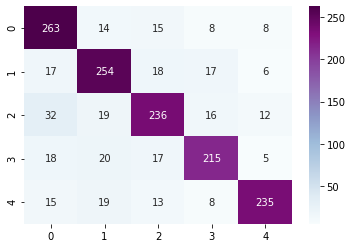

In [45]:
kernel='linear'
gamma='scale'
C=1.0 #default
clf_svm_linear = SVC(kernel=kernel,gamma=gamma, C=C)
start_time = time.time()
clf_svm_linear.fit(X_train_, y_train_)
y_pred = clf_svm_linear.predict(X_dev_)
runtime_linear_SVM = time.time()-start_time
print("Total runtime: ",runtime_linear_SVM,"s")
acc_linear_SVM = Print_Classification_Results(y_dev_,y_pred)

## 2. Logistic Regression

C:\Users\xenia\anaconda3\envs\assignment\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Total runtime:  24.064727306365967 s
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       308
           1       0.86      0.81      0.83       312
           2       0.79      0.78      0.78       315
           3       0.82      0.81      0.82       275
           4       0.77      0.83      0.80       290

    accuracy                           0.81      1500
   macro avg       0.81      0.81      0.81      1500
weighted avg       0.81      0.81      0.81      1500


Accuracy Score:  80.800%


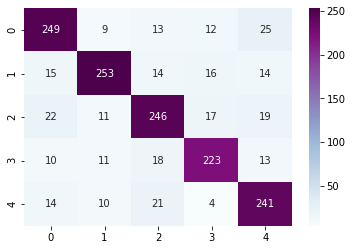

In [21]:
clf_lr_base = LogisticRegression()
start_time = time.time()
clf_lr_base.fit(X_train_, y_train_)
y_pred = clf_lr_base.predict(X_dev_)
runtime_lr_base = time.time()-start_time
print("Total runtime: ",runtime_lr_base,"s")
acc_lr_base = Print_Classification_Results(y_dev_,y_pred)

# Preproccessing Data

## 1. Crop Images

***Since each and every cartoon image in our custom dataset is centered, we crop all images holding only the frame (set height, width offsets manually) that covers the eyes with some extra padding to guarantee that always the eyes will be concluded.***

### Example of cropped images:

Step 1 image size: (500, 500, 3)
Step 2 image size: (110, 110, 3)
Step 3 image size: (30, 50, 3)


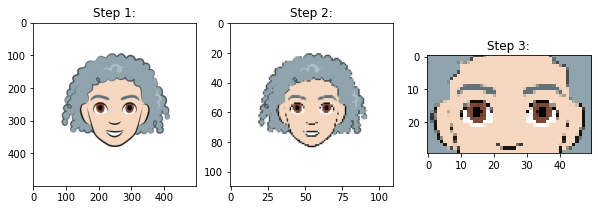

In [13]:
EXAMPLE_PIC = images_folder + '4.png'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

#original image size = (500,500,3)
img_original = load_img(EXAMPLE_PIC,target_size=(500,500))
ax1.imshow(img_original)
ax1.set_title("Step 1:")
print("Step 1 image size:",img_to_array(img_original).shape)

#reduced image size = (150,150,3)
img = load_img(EXAMPLE_PIC,target_size=(110,110))
ax2.imshow(img)
ax2.set_title("Step 2:")
print("Step 2 image size:",img_to_array(img).shape)

#cropped image size = (30,50,3)
x=img_to_array(img)
offset_height=40
offset_width=30
target_height=30
target_width=50
x_cropped = tf.image.crop_to_bounding_box(
    x, offset_height, offset_width, target_height, target_width
)
x_cropped =tf.keras.preprocessing.image.array_to_img(
    x_cropped, data_format=None, scale=True, dtype=None)
ax3.imshow(x_cropped)
ax3.set_title("Step 3:")
print("Step 3 image size:",img_to_array(x_cropped).shape)

plt.show()

### Create new flattened dataset

In [29]:
size=(110,110)
crop_bool = True
reshaped_images_cropped=create_flattened_dataset(images,size,crop_bool)
X_train, X_test, X_dev, y_train, y_test, y_dev=train_dev_test_split(reshaped_images_cropped, labels)

Train Set: (7000, 4500) | Dev Set: (1500, 4500) | Test Set: (1500, 4500)


# Baseline Multiclass Classification for Cropped Images

## 1. Linear SVC

* Perform GridSearch to find best fitted estimator.
* Fit Train Data on estimators and predict on Dev Data

**We dont use the original function of GridSearch since cross validation that it supports, requires too much computational resources that we dont have, so we always train our models on Train set and validate them on Dev Set.**

Score: 0.82 for Parameters: {'Gamma': 'scale', 'C': 1}
Score: 0.82 for Parameters: {'Gamma': 'scale', 'C': 10}
Score: 0.82 for Parameters: {'Gamma': 'scale', 'C': 100}
Score: 0.82 for Parameters: {'Gamma': 'auto', 'C': 1}
Score: 0.82 for Parameters: {'Gamma': 'auto', 'C': 10}
Score: 0.82 for Parameters: {'Gamma': 'auto', 'C': 100}

Best score: 0.82
Best parameters: {'Gamma': 'scale', 'C': 100}
Total runtime:  149.88716077804565 s
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       308
           1       0.78      0.85      0.81       312
           2       0.84      0.79      0.82       315
           3       0.86      0.79      0.83       275
           4       0.89      0.82      0.85       290

    accuracy                           0.82      1500
   macro avg       0.83      0.82      0.82      1500
weighted avg       0.82      0.82      0.82      1500


Accuracy Score:  82.000%


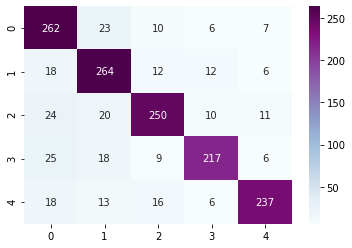

In [16]:
#X = pd.concat([X_train,X_dev])
#y = pd.concat([y_train,y_dev])

# defining parameter range 
C = [1, 10, 100]
gamma= ['scale','auto']
kernel = 'linear'

scores=[]
best_score = 0

for g in gamma:
    for c_ in C:
        clf_svc = SVC(gamma = g, C = c_, kernel = kernel)
        clf_svc.fit(X_train, y_train)
        # evaluate the LR on the dev set
        score = clf_svc.score(X_dev, y_dev)
        scores.append(score)
        parameters={'Gamma':g, 'C':c_}
        print("Score: {:.2f}".format(score), "for Parameters: {}".format(parameters))
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'Gamma':g, 'C':c_}


Total runtime:  284.358820438385 s
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       308
           1       0.82      0.84      0.83       312
           2       0.82      0.80      0.81       315
           3       0.81      0.83      0.82       275
           4       0.85      0.82      0.84       290

    accuracy                           0.82      1500
   macro avg       0.83      0.82      0.82      1500
weighted avg       0.82      0.82      0.82      1500


Accuracy Score:  82.467%


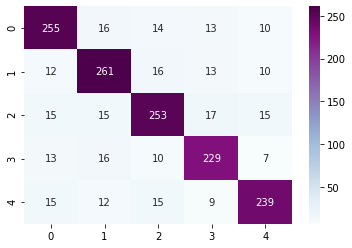

In [20]:
#for optimal parameters take classification report
clf_svc_linear = SVC(gamma = best_parameters['Gamma'], C = best_parameters['C'], kernel =  kernel)
start_time = time.time()
# Train the model using the training sets
clf_svc_linear.fit(X_train, y_train)
preds_svc_linear= clf_svc_linear.predict(X_dev)
print("Total runtime: ",time.time()-start_time,"s")
acc_svc_linear = Print_Classification_Results(y_dev,preds_svc_linear)

## 2. SVC with RBF kernel

Score: 0.80 for Parameters: {'Gamma': 0.01, 'C': 1}
Score: 0.80 for Parameters: {'Gamma': 0.01, 'C': 10}
Score: 0.80 for Parameters: {'Gamma': 0.01, 'C': 100}
Score: 0.82 for Parameters: {'Gamma': 0.001, 'C': 1}
Score: 0.83 for Parameters: {'Gamma': 0.001, 'C': 10}
Score: 0.82 for Parameters: {'Gamma': 0.001, 'C': 100}
Score: 0.74 for Parameters: {'Gamma': 0.0001, 'C': 1}
Score: 0.82 for Parameters: {'Gamma': 0.0001, 'C': 10}
Score: 0.83 for Parameters: {'Gamma': 0.0001, 'C': 100}

Best score: 0.83
Best parameters: {'Gamma': 0.0001, 'C': 100}
Total runtime:  164.15012526512146 s
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       308
           1       0.86      0.84      0.85       312
           2       0.85      0.79      0.82       315
           3       0.81      0.83      0.82       275
           4       0.80      0.86      0.83       290

    accuracy                           0.83      1500
   macro avg       0.83      0.83 

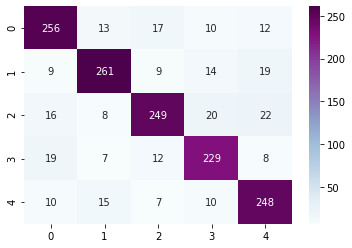

In [17]:
#X = pd.concat([X_train,X_dev])
#y = pd.concat([y_train,y_dev])

# defining parameter range 
C = [1, 10, 100]
gamma= [1e-2, 1e-3, 1e-4]
kernel = 'rbf'

scores=[]
best_score_rbf = 0

for g in gamma:
    for c_ in C:
        clf_svc = SVC(gamma = g, C = c_, kernel = kernel)
        clf_svc.fit(X_train, y_train)
        # evaluate the LR on the dev set
        score = clf_svc.score(X_dev, y_dev)
        scores.append(score)
        parameters={'Gamma':g, 'C':c_}
        print("Score: {:.2f}".format(score), "for Parameters: {}".format(parameters))
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score_rbf = score
            best_parameters_rbf = {'Gamma':g, 'C':c_}
print("\nBest score: {:.5f}".format(best_score_rbf))
print("Best parameters: {}".format(best_parameters_rbf))

#for optimal parameters take classification report
clf_svc_rbf = SVC(gamma = best_parameters_rbf['Gamma'], C = best_parameters_rbf['C'], kernel =  kernel)
start_time = time.time()
# Train the model using the training sets
clf_svc_rbf.fit(X_train, y_train)
preds_svc_rbf= clf_svc_rbf.predict(X_dev)
print("Total runtime: ",time.time()-start_time,"s")
acc_svc_rbf = Print_Classification_Results(y_dev,preds_svc_rbf)

## 3. kNN

Find optimal kNN

5
Score: 0.35667 for Parameter: {'kNN': 5}
10
Score: 0.39933 for Parameter: {'kNN': 10}
15
Score: 0.39867 for Parameter: {'kNN': 15}
20
Score: 0.42200 for Parameter: {'kNN': 20}
25
Score: 0.44533 for Parameter: {'kNN': 25}
30
Score: 0.44600 for Parameter: {'kNN': 30}
35
Score: 0.44533 for Parameter: {'kNN': 35}
40
Score: 0.47000 for Parameter: {'kNN': 40}
45
Score: 0.46667 for Parameter: {'kNN': 45}


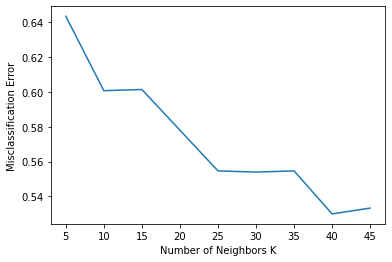

The optimal number of neighbors (calculated in the training set) is 40

Best score: 0.47000
Best parameter: {'C': 40}


In [21]:
myList = list(range(1,50))
neighbors_l = list(filter(lambda x: x % 5 == 0, myList))
# empty list that will hold cv scores
scores = []
best_score_kNN = 0
# perform 5-fold cross validation
for k in neighbors_l:
    print(k)
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    # evaluate the SVC on the dev set
    score = knn.score(X_dev, y_dev)
    scores.append(score)
    parameter={'kNN':k}
    print("Score: {:.5f}".format(score), "for Parameter: {}".format(parameter))
    # if we got a better score, store the score and parameters
    if score > best_score:
        best_score_kNN = score
        best_parameter_kNN = {'C': k}
        
mean_error = [1 - x for x in scores]

# plot misclassification error vs k
plt.plot(neighbors_l, mean_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

# determining best k
optimal_k = neighbors_l[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)
print("\nBest score: {:.5f}".format(best_score_kNN))
print("Best parameter: {}".format(best_parameter_kNN))

**kNN doesnt work decently for our data, given some usual values to parameter k, so we abandon this model since even if we increase value of k, our model will need nuch more computational resources, that actually is useless since other machine learning algorithms satisfy our goal.**

## 4. Logistic Regression

* Score: 0.81867 for Parameters: {'Penalty': 'l1', 'C': 0.01}
* Score: 0.82000 for Parameters: {'Penalty': 'l1', 'C': 0.1}
* Score: 0.84400 for Parameters: {'Penalty': 'l1', 'C': 1}
* Score: 0.83867 for Parameters: {'Penalty': 'l1', 'C': 10}
* Score: 0.83333 for Parameters: {'Penalty': 'l1', 'C': 50}
* Score: 0.81933 for Parameters: {'Penalty': 'l2', 'C': 0.01}
* Score: 0.83867 for Parameters: {'Penalty': 'l2', 'C': 0.1}
* Score: 0.83733 for Parameters: {'Penalty': 'l2', 'C': 1}
* Score: 0.83467 for Parameters: {'Penalty': 'l2', 'C': 10}
* Score: 0.83533 for Parameters: {'Penalty': 'l2', 'C': 50}


Best score: 0.84400
Best parameters: {'Penalty': 'l1', 'C': 1}
Total runtime:  17.177119970321655 s
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       308
           1       0.87      0.84      0.85       312
           2       0.88      0.82      0.85       315
           3       0.81      0.87      0.84       275
           4       0.83      0.86      0.84       290

    accuracy                           0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.84      0.84      0.84      1500


Accuracy Score:  84.333%


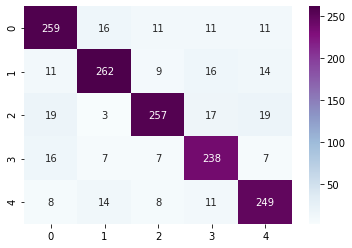

In [61]:
#For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and‘lbfgs’ handle multinomial loss;
# ‘liblinear’ is limited to one-versus-rest schemes

C = [0.01,0.1,1,10,50]
penalty = ['l1','l2']
solver = ['liblinear']

scores=[]
best_score = 0
for p in penalty:
    for c_ in C:
        clf_lr = LogisticRegression( C = c_, solver = s, penalty = p)
        clf_lr.fit(X_train, y_train)
        # evaluate the LR on the dev set
        score = clf_lr.score(X_dev, y_dev)
        scores.append(score)
        parameters={'Penalty': p, 'C':c_}
        print("Score: {:.5f}".format(score), "for Parameters: {}".format(parameters))
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'Penalty': p, 'C':c_}
print("\nBest score: {:.5f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

#for optimal parameters take classification report
clf_lr = LogisticRegression(solver = 'liblinear', penalty = best_parameters['Penalty'], C = best_parameters['C'])
start_time = time.time()
# Train the model using the training sets
clf_lr.fit(X_train, y_train)
preds_lr= clf_lr.predict(X_dev)
print("Total runtime: ",time.time()-start_time,"s")
acc_lr = Print_Classification_Results(y_dev,preds_lr)

## Final Baseline Classifier

In [62]:
data={'Linear SVM':[acc_linear_SVM],'Linear SVC(Gamma: scale, C: 100) - cropped':[acc_svc_linear],
      'RBF SVC(Gamma: 0.0001,C: 100) - cropped':[acc_svc_rbf ],
      'kNN {}'.format(optimal_k):[best_score_kNN],'Logistic Regression {}'.format(best_parameters):[acc_lr]}
df=pd.DataFrame.from_dict(data,orient='index',columns=['Accuracy Score'])
df.sort_values(by=df.columns[0],ascending=False, inplace=False)

,Accuracy Score
"Logistic Regression {'Penalty': 'l1', 'C': 1}",0.843333
"RBF SVC(Gamma: 0.0001,C: 100) - cropped",0.828667
"Linear SVC(Gamma: scale, C: 100) - cropped",0.824667
Linear SVM,0.802000
kNN 40,0.470000


Hence the classifier **{Logistic Regression with Penalty='l1', C=1.0, solver='liblinear'}** is the best baseline classifier for unpreprocessed data.

# Preprocessing Data - Curse of Dimensionality

Since our cropped dataset doesn't have obvious features-pixels with zero variance, hence we have no evident redundant features, we perform directly Feature Extraction (PCA) rather than Feature Selection(Variance Threshold)

## Feature Extraction - PCA

(7000, 4500)
(7000, 300)
[0.99554294 0.99550647 0.99546945 0.99543184 0.9953939  0.9953551
 0.995316   0.9952765  0.99523693]


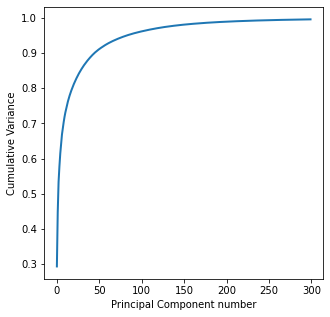

In [30]:
n = 300
pca = PCA(n_components=n)
X_train_PCA = pca.fit_transform(X_train)
X_dev_PCA = pca.transform(X_dev)
X_test_PCA = pca.transform(X_test)
print(X_train.shape)
print(X_train_PCA.shape)

evar = pca.explained_variance_ratio_
cum_evar = np.cumsum(evar)
print(cum_evar[:-10:-1])
plt.figure(1, figsize=(5, 5))
plt.xlabel("Principal Component number")
plt.ylabel('Cumulative Variance')
plt.plot(cum_evar, linewidth=2)
plt.show()

From this plot we can infer what amount of variance is represented by the corresponding number of PCA components.
Almost 90% of the information given from features is explained by 50 PCA components.

### Logistic Regression (Penalty='l1', C=1.0, solver='liblinear')

Total runtime:  12.984297752380371 s
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       308
           1       0.85      0.84      0.84       312
           2       0.88      0.82      0.85       315
           3       0.84      0.85      0.85       275
           4       0.82      0.86      0.84       290

    accuracy                           0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.84      0.84      0.84      1500


Accuracy Score:  84.400%


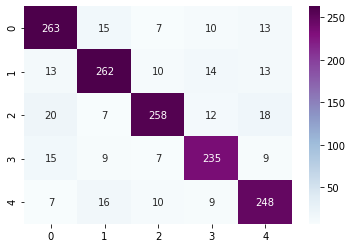

In [87]:
clf_lr_PCA = LogisticRegression(solver = 'liblinear', penalty ='l1', C = 1.0)
start_time = time.time()
clf_lr_PCA.fit(X_train_PCA, y_train)
preds_lr_PCA= clf_lr_PCA.predict(X_dev_PCA)
print("Total runtime: ",time.time()-start_time,"s")
acc_lr_PCA = Print_Classification_Results(y_dev,preds_lr_PCA)

# Compare all previous models

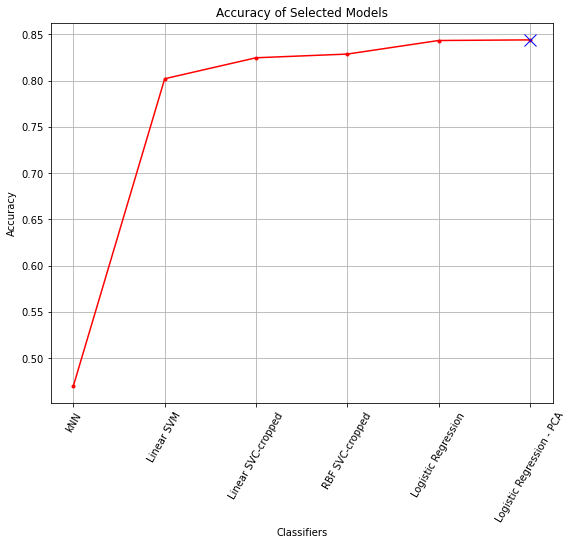

Best Clasifier till now: Logistic Regression with Parameters {'Penalty': 'l1', 'C': 1} 
and PCA preprocessing with n_components = 300 
and accuracy = 84.40%


In [133]:
accuracies = [best_score_kNN, acc_linear_SVM, acc_svc_linear, acc_svc_rbf, acc_lr, acc_lr_PCA]
accuracies = np.array(accuracies)
acc_list=['kNN','Linear SVC','Linear SVC-cropped','RBF SVC-cropped',
           'Logistic Regression', 'Logistic Regression - PCA']

plt.figure(figsize=(9,7))
plt.title('Accuracy of Selected Models')
plt.plot(acc_list,accuracies, 'r.-')

#spot maximum accuracy
acc_max = np.array(accuracies).max()
index=np.where(accuracies==acc_max)
index = index[0][0]
plt.plot(acc_list[index],acc_max,'x',color='b',markersize=12)

plt.ylabel('Accuracy')
plt.xlabel('Classifiers')
plt.xticks(rotation=60)
plt.grid()
plt.show()

print('Best Clasifier till now: Logistic Regression with Parameters {}'.format(best_parameters),
      '\nand PCA preprocessing with n_components = 300', '\nand accuracy = {:.2%}'.format(acc_max))

# CNN

In [182]:
def cnn(IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, EPOCHS, opt, Xtrain, ytrain, Xdev, ydev, dim, checkpointer, checkpoint_filepath):
    print('Build model...')
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same',kernel_initializer=TruncatedNormal(stddev=0.1), input_shape=(IMG_HEIGHT, IMG_WIDTH,dim)))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Flatten())
    model.add(Dense(128, activation='relu',kernel_initializer=TruncatedNormal(stddev=0.1)))
    model.add(Dropout(0.3)) 
    model.add(Dense(5, activation='softmax',kernel_initializer=TruncatedNormal(stddev=0.1)))

    # Compile the network :
    model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
    model.summary()
    
    history=model.fit(Xtrain, ytrain, validation_data=(Xdev, ydev), batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,callbacks=[checkpointer])
    model.load_weights(checkpoint_filepath)
    y_pred = model.predict_classes(Xdev)
    
    return(model, history, y_pred)

## Convert images dataframe to multidimensional array images dataframe

In [159]:
#create dataset with original size of images
X_train_d = X_train.to_numpy()
X_dev_d = X_dev.to_numpy()
X_test_d = X_test.to_numpy()
print('Before: ', X_train_d.shape, X_dev_d.shape)
X_train_d=X_train_d.reshape((X_train_d.shape[0], 30, 50, 3))
X_dev_d=X_dev_d.reshape((X_dev_d.shape[0], 30, 50, 3))
X_test_d=X_test_d.reshape((X_test_d.shape[0], 30, 50, 3))
print('After: ', X_train_d.shape, X_dev_d.shape)

#convert labels to one-hot encoding vectors
y_train_c = to_categorical(y_train)
y_dev_c = to_categorical(y_dev)
y_test_c = to_categorical(y_test)

Before:  (7000, 4500) (1500, 4500)
After:  (7000, 30, 50, 3) (1500, 30, 50, 3)


## Architecture: One convolutional layer and the one dense layer with dropout between dense layer and output layer

Build model...
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 30, 50, 32)        896       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 15, 25, 32)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 12000)             0         
_________________________________________________________________
dense_41 (Dense)             (None, 128)               1536128   
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 5)                 645       
Total params: 1,537,669
Trainable params: 1,537,669
Non-trainable params: 0
____________________________

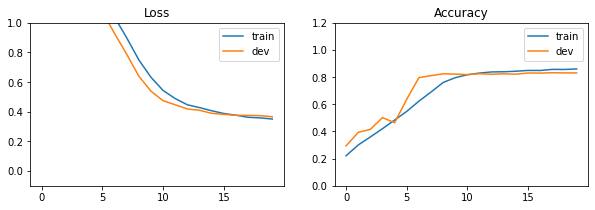

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       308
           1       0.93      0.80      0.86       312
           2       0.91      0.78      0.84       315
           3       0.77      0.86      0.81       275
           4       0.76      0.89      0.82       290

    accuracy                           0.83      1500
   macro avg       0.84      0.83      0.83      1500
weighted avg       0.84      0.83      0.83      1500


Accuracy Score:  83.067%


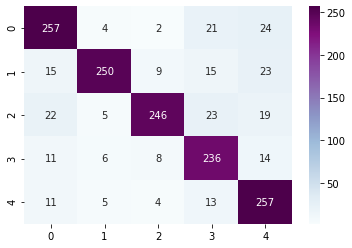

In [185]:
IMG_HEIGHT = 30
IMG_WIDTH = 50
BATCH_SIZE = 500
EPOCHS = 20
dim = 3
checkpoint_filepath = 'weights.best.model.hdf5'
checkpointer = ModelCheckpoint(filepath=checkpoint_filepath, 
                               verbose=1, save_best_only=True)


opt = keras.optimizers.Adam() #Adagrad() #SGD(lr=0.01, momentum=0.9, decay=0.01)
start_time = time.time()
model, history, y_pred = cnn(IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, EPOCHS, opt, X_train_d, y_train_c, X_dev_d, y_dev_c, dim,  checkpointer, checkpoint_filepath)
runtime = time.time()-start_time
print("Total runtime: ",runtime,"s")
print(model.metrics_names)
print(model.evaluate(X_train_d, y_train_c))

accuracy = evaluate_and_plot(model, history, X_train_d, y_train, X_dev_d, y_dev, y_pred)

After trying multiple architectures with simple and more complex layers and filters, we conclude that they can't outperform simpler ML algorithms that we tested previously, beyond that they need more computational and memory resources.

# Best model

As we said previously, best model for outask is a Logistic Regression with Parameters {'Penalty': 'l1', 'C': 1} 
and PCA preprocessing with n_components = 300. which gives and accuracy = 84.40%

## Evaluate on Dev Set:

Total runtime:  11.855462551116943 s
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       308
           1       0.85      0.84      0.85       312
           2       0.87      0.82      0.84       315
           3       0.84      0.85      0.84       275
           4       0.82      0.85      0.84       290

    accuracy                           0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.84      0.84      0.84      1500


Accuracy Score:  84.133%


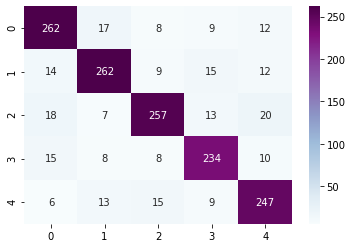

In [32]:
clf_lr_PCA = LogisticRegression(solver = 'liblinear', penalty = 'l1', C = 1.0 )
start_time = time.time()
# Train the model using the training sets
clf_lr_PCA.fit(X_train_PCA, y_train)
preds= clf_lr_PCA.predict(X_dev_PCA)
print("Total runtime: ",time.time()-start_time,"s")
accuracy = Print_Classification_Results(y_dev,preds)

## Evaluate on Test Set:

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       312
           1       0.83      0.85      0.84       281
           2       0.83      0.84      0.84       299
           3       0.86      0.84      0.85       296
           4       0.82      0.83      0.83       312

    accuracy                           0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.84      0.84      0.84      1500


Accuracy Score:  84.333%


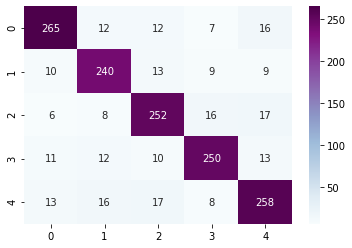

In [56]:
preds = clf_lr_PCA.predict(X_test_PCA)
accuracy_test = Print_Classification_Results(y_test,preds)

* Our model is almost perfect if we take into consideration that a great amount of cartoons wear sun glasses which makes  the recognition of their eye color impossible. Hence their allocation to any of 5 classes becomes based on some other patterns of their features that models has been trained to recognised, which features actually can't contribute to the eye color classification since all cartoons irrespective of eye color, share characteristics from a specific range (in simple words eye color is an independent variable to the other features, see below for justification).

* Each cartoon face is composed of 16 components including 12 facial attributes (e.g., facial hair, eye shape, etc) and 4 color attributes (such as skin or hair color) which are chosen from a discrete set of RGB values. The number of options per attribute category ranges from 3 to 111, for the largest category, hairstyle. Each of these components and their variation were drawn by the same artist, resulting in approximately 250 cartoon components artworks and 108 possible combinations. Hence the patterns that our model creates are based only on the surface of eyes, so cartoons with sunglasses are misclassified (or true classified by chance) and this fact skew decision boundaries of our model space.


## Compare Baseline and Best model's Accurracy on Test Set¶

**Baseline model vs Best model**

* *Estimator*: Logistic Regression with Default Parameters {'kernel': 'lbfgs','Penalty': 'l2', 'C': 1} **vs** Logistic Regression with Parameters {'kernel': 'liblinear','Penalty': 'l1', 'C': 1}
* *Training Data*: Flattened images of size=(110,110) in RGB scale **vs** Cropped Flattened images of size=(30,50) in RGB scale before fed to PCA preprocessing with n_components = 300, which means that our model reaches better accuracy **with much lesser amount of features**.


Accuracy Score of Test Set for Baseline Model:  81.400%

Accuracy Score of Test Set for Best Model:  84.200%


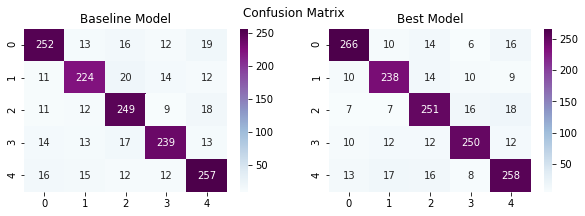

In [34]:
#Baseline model
preds_lr_base= clf_lr_base.predict(X_test_)
acc_lr_base = accuracy_score(y_test_, preds_lr_base)
print("\nAccuracy Score of Test Set for Baseline Model: ","{:.3%}".format(acc_lr_base))
conf_matrix1 = confusion_matrix(y_test_, preds_lr_base)

#Best model
preds= clf_lr_PCA.predict(X_test_PCA)
accuracy = accuracy_score(y_test,preds)
print("\nAccuracy Score of Test Set for Best Model: ","{:.3%}".format(accuracy))
conf_matrix2 = confusion_matrix(y_test, preds)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
fig.suptitle('Confusion Matrix', fontsize=12)
labels=['0','1','2','3','4']

ax1.set_title('Baseline Model')
sns.heatmap(conf_matrix1, annot=True, fmt='g', xticklabels=labels, yticklabels=labels,cmap= "BuPu",ax=ax1)

ax2.set_title('Best Model')
sns.heatmap(conf_matrix2, annot=True, fmt='g', xticklabels=labels, yticklabels=labels,cmap= "BuPu",ax=ax2)
plt.show()

**Since our model enhanced the accuracy of prediction on Test Data too, means that we neither overfit our model on Train Data, nor fined-tune it on Validation (Dev) Data.**